## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp020'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 5e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

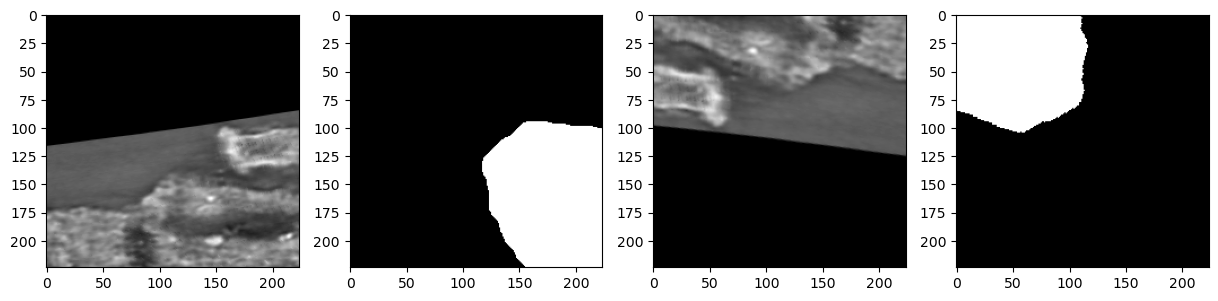

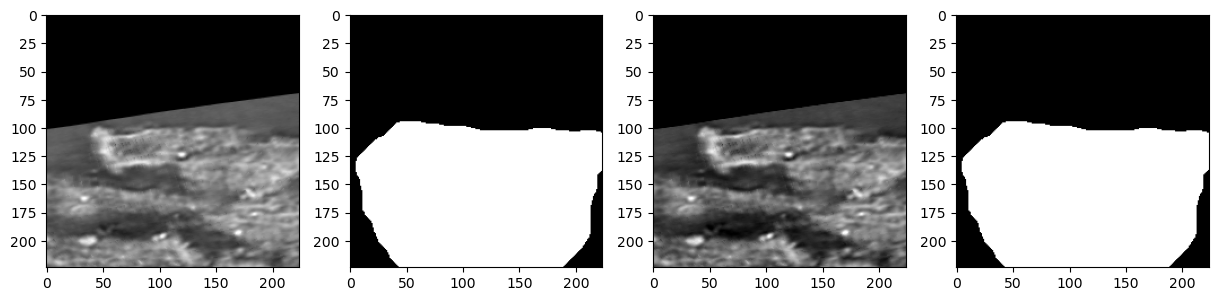

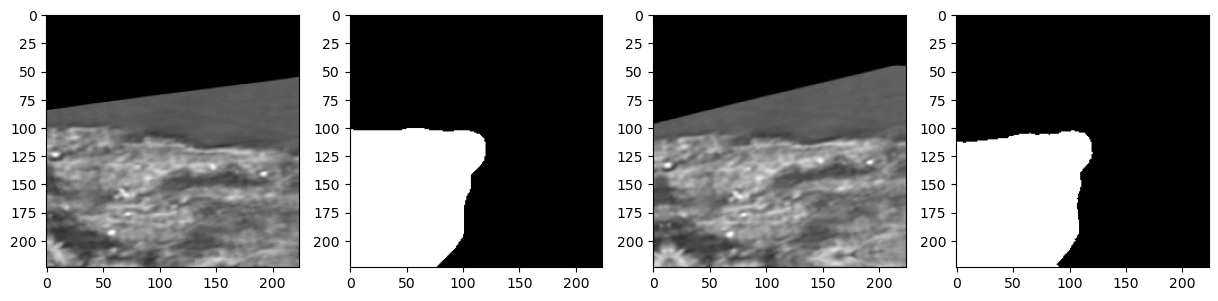

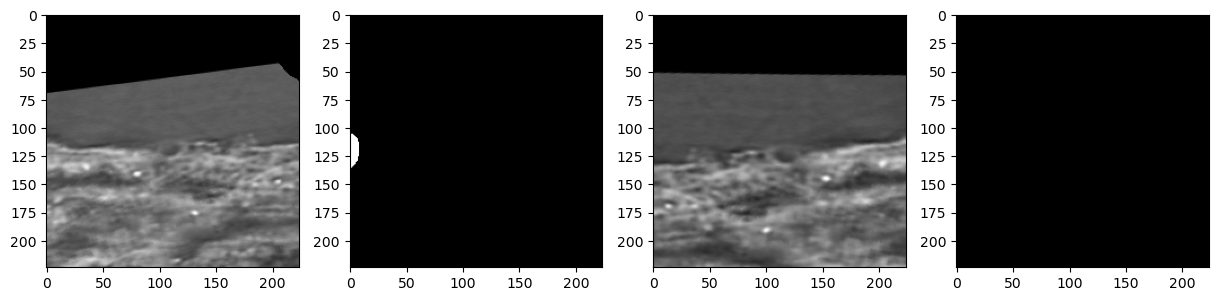

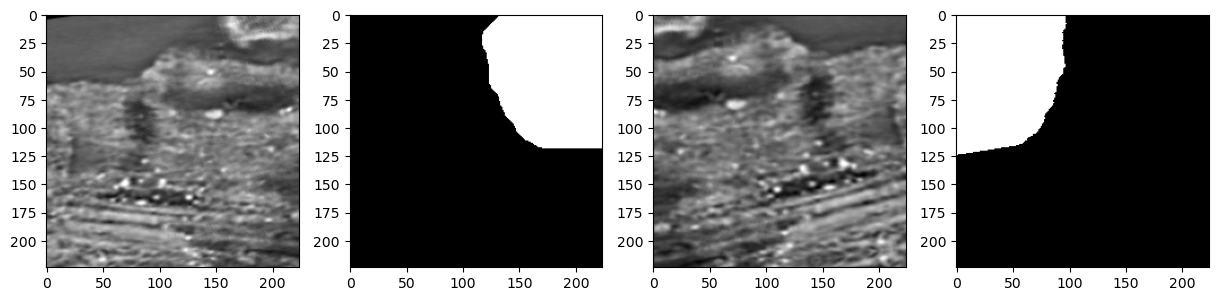

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48150

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.16945068651483677
th: 0.15, fbeta: 0.2726017585936104
th: 0.2, fbeta: 0.36659265840341776
th: 0.25, fbeta: 0.4319809369534643
th: 0.3, fbeta: 0.46541410068304934
th: 0.35, fbeta: 0.4780328204745558
th: 0.4, fbeta: 0.47291431154304786
th: 0.45, fbeta: 0.4423566391280417


best_th: 0.35, fbeta: 0.4780328204745558
Epoch 1 - avg_train_loss: 0.3814  avg_val_loss: 0.2273  time: 153s
Epoch 1 - avgScore: 0.4780
Epoch 1 - Save Best Score: 0.4780 Model
Epoch 1 - Save Best Loss: 0.2273 Model


th: 0.5, fbeta: 0.40000318204587615


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37043309043670114
th: 0.15, fbeta: 0.45845858680267065
th: 0.2, fbeta: 0.47879053668629307
th: 0.25, fbeta: 0.47702611544355555
th: 0.3, fbeta: 0.4684523320260799
th: 0.35, fbeta: 0.4533739781348118
th: 0.4, fbeta: 0.4315130294785306
th: 0.45, fbeta: 0.4008167944907643


best_th: 0.2, fbeta: 0.47879053668629307
Epoch 2 - avg_train_loss: 0.2705  avg_val_loss: 0.2042  time: 158s
Epoch 2 - avgScore: 0.4788
Epoch 2 - Save Best Score: 0.4788 Model
Epoch 2 - Save Best Loss: 0.2042 Model


th: 0.5, fbeta: 0.350657554679491


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.18892523492186258
th: 0.15, fbeta: 0.2263384620893274
th: 0.2, fbeta: 0.277110080898123
th: 0.25, fbeta: 0.3034366924441188
th: 0.3, fbeta: 0.32434438073674254
th: 0.35, fbeta: 0.3457139291435553
th: 0.4, fbeta: 0.36909030354979355


best_th: 0.5, fbeta: 0.43406308375630964
Epoch 3 - avg_train_loss: 0.2907  avg_val_loss: 0.2352  time: 159s
Epoch 3 - avgScore: 0.4341


th: 0.45, fbeta: 0.39540821652171715
th: 0.5, fbeta: 0.43406308375630964


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2326762940554288
th: 0.15, fbeta: 0.29462366219393527
th: 0.2, fbeta: 0.3434335194691077
th: 0.25, fbeta: 0.37648308730619195
th: 0.3, fbeta: 0.40773878822372345
th: 0.35, fbeta: 0.43965292754845803
th: 0.4, fbeta: 0.4699355105707724
th: 0.45, fbeta: 0.4982434285344571


best_th: 0.5, fbeta: 0.5172300361934518
Epoch 4 - avg_train_loss: 0.2749  avg_val_loss: 0.2066  time: 160s
Epoch 4 - avgScore: 0.5172
Epoch 4 - Save Best Score: 0.5172 Model
Epoch 4 - Save Best Loss: 0.2066 Model


th: 0.5, fbeta: 0.5172300361934518


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2949049712715719
th: 0.15, fbeta: 0.35707524729062917
th: 0.2, fbeta: 0.4153735000352815
th: 0.25, fbeta: 0.46935849272852387
th: 0.3, fbeta: 0.5183623122495914
th: 0.35, fbeta: 0.5550067487204461
th: 0.4, fbeta: 0.5715363850986651


best_th: 0.4, fbeta: 0.5715363850986651
Epoch 5 - avg_train_loss: 0.2662  avg_val_loss: 0.1813  time: 160s
Epoch 5 - avgScore: 0.5715
Epoch 5 - Save Best Score: 0.5715 Model
Epoch 5 - Save Best Loss: 0.1813 Model


th: 0.45, fbeta: 0.5664377246332558
th: 0.5, fbeta: 0.5436371559815995


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35451426649459417
th: 0.15, fbeta: 0.49202751826181745
th: 0.2, fbeta: 0.5468782561814083
th: 0.25, fbeta: 0.5567805207015685
th: 0.3, fbeta: 0.5421042456620841
th: 0.35, fbeta: 0.5152394886630904
th: 0.4, fbeta: 0.47952503340944214
th: 0.45, fbeta: 0.4390505005286625


best_th: 0.25, fbeta: 0.5567805207015685
Epoch 6 - avg_train_loss: 0.2618  avg_val_loss: 0.1933  time: 159s
Epoch 6 - avgScore: 0.5568


th: 0.5, fbeta: 0.38593985648910706


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2889873253653888
th: 0.15, fbeta: 0.3584710495647461
th: 0.2, fbeta: 0.4120808439379176
th: 0.25, fbeta: 0.45329465398815394
th: 0.3, fbeta: 0.48635077202007043
th: 0.35, fbeta: 0.5117222270901032
th: 0.4, fbeta: 0.5265158939848644
th: 0.45, fbeta: 0.539105489815381


best_th: 0.5, fbeta: 0.5493710133882073
Epoch 7 - avg_train_loss: 0.2570  avg_val_loss: 0.1926  time: 159s
Epoch 7 - avgScore: 0.5494


th: 0.5, fbeta: 0.5493710133882073


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3801562009406705
th: 0.15, fbeta: 0.44487034470078884
th: 0.2, fbeta: 0.4904923177201141
th: 0.25, fbeta: 0.5282086394611022
th: 0.3, fbeta: 0.5599437404908201
th: 0.35, fbeta: 0.5791617736063481
th: 0.4, fbeta: 0.5820742068182331
th: 0.45, fbeta: 0.5702470526054695


best_th: 0.4, fbeta: 0.5820742068182331
Epoch 8 - avg_train_loss: 0.2499  avg_val_loss: 0.1836  time: 160s
Epoch 8 - avgScore: 0.5821
Epoch 8 - Save Best Score: 0.5821 Model
Epoch 8 - Save Best Loss: 0.1836 Model


th: 0.5, fbeta: 0.5513383179453186


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23651667908853916
th: 0.15, fbeta: 0.28851842595695115
th: 0.2, fbeta: 0.3237984302843724
th: 0.25, fbeta: 0.3558295788776015
th: 0.3, fbeta: 0.38478858501371316
th: 0.35, fbeta: 0.4124377044831404
th: 0.4, fbeta: 0.4334578706221893
th: 0.45, fbeta: 0.45861336610719494


best_th: 0.5, fbeta: 0.4923848356669093
Epoch 9 - avg_train_loss: 0.2465  avg_val_loss: 0.2110  time: 159s
Epoch 9 - avgScore: 0.4924


th: 0.5, fbeta: 0.4923848356669093


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31028002384160824
th: 0.15, fbeta: 0.3819628842328529
th: 0.2, fbeta: 0.4410156691274766
th: 0.25, fbeta: 0.4834076454919754
th: 0.3, fbeta: 0.5121784637878303
th: 0.35, fbeta: 0.5366034945580227
th: 0.4, fbeta: 0.5512709526590128


best_th: 0.45, fbeta: 0.5600867673226827
Epoch 10 - avg_train_loss: 0.2410  avg_val_loss: 0.1892  time: 160s
Epoch 10 - avgScore: 0.5601


th: 0.45, fbeta: 0.5600867673226827
th: 0.5, fbeta: 0.5586404488262837


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2832214737934738
th: 0.15, fbeta: 0.3371215606814462
th: 0.2, fbeta: 0.38949687464145993
th: 0.25, fbeta: 0.43989241295025316
th: 0.3, fbeta: 0.48396128998824955
th: 0.35, fbeta: 0.5194056197825945
th: 0.4, fbeta: 0.5452520910815678
th: 0.45, fbeta: 0.5585738380188955


best_th: 0.5, fbeta: 0.5622999059994848
Epoch 11 - avg_train_loss: 0.2363  avg_val_loss: 0.1897  time: 160s
Epoch 11 - avgScore: 0.5623


th: 0.5, fbeta: 0.5622999059994848


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4215328023980847
th: 0.15, fbeta: 0.4891140304339076
th: 0.2, fbeta: 0.5216698265683153
th: 0.25, fbeta: 0.5491047524242805
th: 0.3, fbeta: 0.5637298817796299
th: 0.35, fbeta: 0.5696447597551726
th: 0.4, fbeta: 0.5635862744621462
th: 0.45, fbeta: 0.5507138300811972


best_th: 0.35, fbeta: 0.5696447597551726
Epoch 12 - avg_train_loss: 0.2318  avg_val_loss: 0.1942  time: 159s
Epoch 12 - avgScore: 0.5696


th: 0.5, fbeta: 0.5334759908797705


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4347006058767986
th: 0.15, fbeta: 0.5066994265218662
th: 0.2, fbeta: 0.543986852250844
th: 0.25, fbeta: 0.5701150471307938
th: 0.3, fbeta: 0.5872937242398729
th: 0.35, fbeta: 0.5974882792630968
th: 0.4, fbeta: 0.597510521423272
th: 0.45, fbeta: 0.5900169147998378


best_th: 0.4, fbeta: 0.597510521423272
Epoch 13 - avg_train_loss: 0.2287  avg_val_loss: 0.1903  time: 160s
Epoch 13 - avgScore: 0.5975
Epoch 13 - Save Best Score: 0.5975 Model
Epoch 13 - Save Best Loss: 0.1903 Model


th: 0.5, fbeta: 0.5763672842574056


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37052453170601274
th: 0.15, fbeta: 0.45138503139307695
th: 0.2, fbeta: 0.5082901739958119
th: 0.25, fbeta: 0.5389424291127415
th: 0.3, fbeta: 0.5523882788441866
th: 0.35, fbeta: 0.5594392160189483
th: 0.4, fbeta: 0.5550084919491017
th: 0.45, fbeta: 0.5423326790751855


best_th: 0.35, fbeta: 0.5594392160189483
Epoch 14 - avg_train_loss: 0.2230  avg_val_loss: 0.1894  time: 159s
Epoch 14 - avgScore: 0.5594


th: 0.5, fbeta: 0.5243357497418333


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3201916772456404
th: 0.15, fbeta: 0.3867321521295212
th: 0.2, fbeta: 0.440953359743379
th: 0.25, fbeta: 0.48134881280674685
th: 0.3, fbeta: 0.5124449629155694
th: 0.35, fbeta: 0.5403368522928936
th: 0.4, fbeta: 0.5569832253639527
th: 0.45, fbeta: 0.5672218942998514


best_th: 0.5, fbeta: 0.5730015191290226
Epoch 15 - avg_train_loss: 0.2179  avg_val_loss: 0.1884  time: 158s
Epoch 15 - avgScore: 0.5730


th: 0.5, fbeta: 0.5730015191290226


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33364550782820773
th: 0.15, fbeta: 0.3920889150543064
th: 0.2, fbeta: 0.4381060854969985
th: 0.25, fbeta: 0.47669128772173486
th: 0.3, fbeta: 0.5052234300553621
th: 0.35, fbeta: 0.5301057450765065
th: 0.4, fbeta: 0.5490346342552807
th: 0.45, fbeta: 0.5644348633712957


best_th: 0.5, fbeta: 0.573022121896016
Epoch 16 - avg_train_loss: 0.2151  avg_val_loss: 0.1889  time: 156s
Epoch 16 - avgScore: 0.5730


th: 0.5, fbeta: 0.573022121896016


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3034510976018297
th: 0.15, fbeta: 0.36377923060910916
th: 0.2, fbeta: 0.4139750835843518
th: 0.25, fbeta: 0.45353072341317
th: 0.3, fbeta: 0.4821688205349509
th: 0.35, fbeta: 0.5056645648702991
th: 0.4, fbeta: 0.526540348893841
th: 0.45, fbeta: 0.5434883149566545


best_th: 0.5, fbeta: 0.5578585057518748
Epoch 17 - avg_train_loss: 0.2075  avg_val_loss: 0.1949  time: 156s
Epoch 17 - avgScore: 0.5579


th: 0.5, fbeta: 0.5578585057518748


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4016136635985564
th: 0.15, fbeta: 0.4766485876082426
th: 0.2, fbeta: 0.524581378715078
th: 0.25, fbeta: 0.5589824962692994
th: 0.3, fbeta: 0.5830798089022636
th: 0.35, fbeta: 0.6009334029018648
th: 0.4, fbeta: 0.6123030407432523
th: 0.45, fbeta: 0.6128546240742728


best_th: 0.45, fbeta: 0.6128546240742728
Epoch 18 - avg_train_loss: 0.2024  avg_val_loss: 0.1910  time: 155s
Epoch 18 - avgScore: 0.6129
Epoch 18 - Save Best Score: 0.6129 Model
Epoch 18 - Save Best Loss: 0.1910 Model


th: 0.5, fbeta: 0.6074936233615558


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35861152207977587
th: 0.15, fbeta: 0.42070927165294747
th: 0.2, fbeta: 0.46680657081641114
th: 0.25, fbeta: 0.5034761555593597
th: 0.3, fbeta: 0.5324848590468481
th: 0.35, fbeta: 0.5587532766288099
th: 0.4, fbeta: 0.5787885492085856
th: 0.45, fbeta: 0.5900161646456374


best_th: 0.5, fbeta: 0.5946402634237892
Epoch 19 - avg_train_loss: 0.1972  avg_val_loss: 0.1836  time: 155s
Epoch 19 - avgScore: 0.5946


th: 0.5, fbeta: 0.5946402634237892


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4413951286455048
th: 0.15, fbeta: 0.5033690289274425
th: 0.2, fbeta: 0.5406675207506347
th: 0.25, fbeta: 0.5641623092422312
th: 0.3, fbeta: 0.5831206206782609
th: 0.35, fbeta: 0.5930774355509708
th: 0.4, fbeta: 0.5998730868576613
th: 0.45, fbeta: 0.5954909299171569


best_th: 0.4, fbeta: 0.5998730868576613
Epoch 20 - avg_train_loss: 0.1919  avg_val_loss: 0.1991  time: 155s
Epoch 20 - avgScore: 0.5999


th: 0.5, fbeta: 0.583828211891395


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3855195315887781
th: 0.15, fbeta: 0.442659540980685
th: 0.2, fbeta: 0.48512038571567123
th: 0.25, fbeta: 0.5216647473741638
th: 0.3, fbeta: 0.5517651143792934
th: 0.35, fbeta: 0.573271510021876
th: 0.4, fbeta: 0.5831510744422256
th: 0.45, fbeta: 0.5863886166699528


best_th: 0.45, fbeta: 0.5863886166699528
Epoch 21 - avg_train_loss: 0.1868  avg_val_loss: 0.1941  time: 155s
Epoch 21 - avgScore: 0.5864


th: 0.5, fbeta: 0.584984419445646


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3441544329322776
th: 0.15, fbeta: 0.3922688607196078
th: 0.2, fbeta: 0.4337285935762436
th: 0.25, fbeta: 0.4668356778821964
th: 0.3, fbeta: 0.5002764391574268
th: 0.35, fbeta: 0.5293720293868278
th: 0.4, fbeta: 0.5542683547096442
th: 0.45, fbeta: 0.5736941508720182


best_th: 0.5, fbeta: 0.5863391038226952
Epoch 22 - avg_train_loss: 0.1818  avg_val_loss: 0.1910  time: 154s
Epoch 22 - avgScore: 0.5863


th: 0.5, fbeta: 0.5863391038226952


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3361885904910801
th: 0.15, fbeta: 0.3876261395573986
th: 0.2, fbeta: 0.4337320407392033
th: 0.25, fbeta: 0.47197510063013837
th: 0.3, fbeta: 0.5058172793508976
th: 0.35, fbeta: 0.535432262018942
th: 0.4, fbeta: 0.5621995229865071
th: 0.45, fbeta: 0.5815589953298036


best_th: 0.5, fbeta: 0.5928532966797914
Epoch 23 - avg_train_loss: 0.1769  avg_val_loss: 0.1903  time: 155s
Epoch 23 - avgScore: 0.5929


th: 0.5, fbeta: 0.5928532966797914


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3605327547014903
th: 0.15, fbeta: 0.41670118607754375
th: 0.2, fbeta: 0.46828922508985377
th: 0.25, fbeta: 0.5157287246020936
th: 0.3, fbeta: 0.5514984704028834
th: 0.35, fbeta: 0.5764873624715914
th: 0.4, fbeta: 0.5955243532441236


best_th: 0.5, fbeta: 0.6100086132062393
Epoch 24 - avg_train_loss: 0.1719  avg_val_loss: 0.1847  time: 154s
Epoch 24 - avgScore: 0.6100


th: 0.45, fbeta: 0.6075773281153833
th: 0.5, fbeta: 0.6100086132062393


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3631102912529715
th: 0.15, fbeta: 0.408686892210833
th: 0.2, fbeta: 0.44851817605347477
th: 0.25, fbeta: 0.48090548891834733
th: 0.3, fbeta: 0.5110216341496872
th: 0.35, fbeta: 0.5346720608071156
th: 0.4, fbeta: 0.555405662214312
th: 0.45, fbeta: 0.5728394570850167


best_th: 0.5, fbeta: 0.5867922181232943
Epoch 25 - avg_train_loss: 0.1695  avg_val_loss: 0.1922  time: 155s
Epoch 25 - avgScore: 0.5868


th: 0.5, fbeta: 0.5867922181232943


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33157555729980326
th: 0.15, fbeta: 0.37533466712940383
th: 0.2, fbeta: 0.41175665820348223
th: 0.25, fbeta: 0.44459418492730096
th: 0.3, fbeta: 0.4768938751700796
th: 0.35, fbeta: 0.5071915919471088
th: 0.4, fbeta: 0.5320825462081502
th: 0.45, fbeta: 0.5517962977086841


best_th: 0.5, fbeta: 0.5669125189255634
Epoch 26 - avg_train_loss: 0.1651  avg_val_loss: 0.1963  time: 154s
Epoch 26 - avgScore: 0.5669


th: 0.5, fbeta: 0.5669125189255634


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3763304457262832
th: 0.15, fbeta: 0.4310941848818293
th: 0.2, fbeta: 0.480751635447974
th: 0.25, fbeta: 0.5202989118109861
th: 0.3, fbeta: 0.5517152358322448
th: 0.35, fbeta: 0.5775394845754792
th: 0.4, fbeta: 0.597182917607067
th: 0.45, fbeta: 0.6079930023679949


best_th: 0.5, fbeta: 0.612891329750372
Epoch 27 - avg_train_loss: 0.1617  avg_val_loss: 0.1883  time: 154s
Epoch 27 - avgScore: 0.6129
Epoch 27 - Save Best Score: 0.6129 Model
Epoch 27 - Save Best Loss: 0.1883 Model


th: 0.5, fbeta: 0.612891329750372


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3373507655432519
th: 0.15, fbeta: 0.386760079506297
th: 0.2, fbeta: 0.43090482603540053
th: 0.25, fbeta: 0.47038795444703324
th: 0.3, fbeta: 0.5054445498929027
th: 0.35, fbeta: 0.5359526779919619
th: 0.4, fbeta: 0.5621135423904133
th: 0.45, fbeta: 0.5822836179343798


best_th: 0.5, fbeta: 0.5943616000161834
Epoch 28 - avg_train_loss: 0.1606  avg_val_loss: 0.1912  time: 156s
Epoch 28 - avgScore: 0.5944


th: 0.5, fbeta: 0.5943616000161834


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37150502063312424
th: 0.15, fbeta: 0.42767963444675255
th: 0.2, fbeta: 0.47113093843046017
th: 0.25, fbeta: 0.5077551992887863
th: 0.3, fbeta: 0.5413553352500313
th: 0.35, fbeta: 0.5666534416029109
th: 0.4, fbeta: 0.5862657232608655
th: 0.45, fbeta: 0.596300973785204


best_th: 0.5, fbeta: 0.6028990362182814
Epoch 29 - avg_train_loss: 0.1579  avg_val_loss: 0.1926  time: 154s
Epoch 29 - avgScore: 0.6029


th: 0.5, fbeta: 0.6028990362182814


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3517372083689354
th: 0.15, fbeta: 0.4005245254404265
th: 0.2, fbeta: 0.44285114499425365
th: 0.25, fbeta: 0.4769850286758829
th: 0.3, fbeta: 0.5080846505792392
th: 0.35, fbeta: 0.5367049487435276
th: 0.4, fbeta: 0.559405359131914
th: 0.45, fbeta: 0.5753135634750353


best_th: 0.5, fbeta: 0.5875659643579972
Epoch 30 - avg_train_loss: 0.1562  avg_val_loss: 0.1970  time: 155s
Epoch 30 - avgScore: 0.5876


th: 0.5, fbeta: 0.5875659643579972


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3763304457262832
th: 0.15, fbeta: 0.4310941848818293
th: 0.2, fbeta: 0.480751635447974
th: 0.25, fbeta: 0.5202989118109861
th: 0.3, fbeta: 0.5517152358322448
th: 0.35, fbeta: 0.5775394845754792
th: 0.4, fbeta: 0.597182917607067


best_th: 0.5, fbeta: 0.612891329750372


th: 0.45, fbeta: 0.6079930023679949
th: 0.5, fbeta: 0.612891329750372


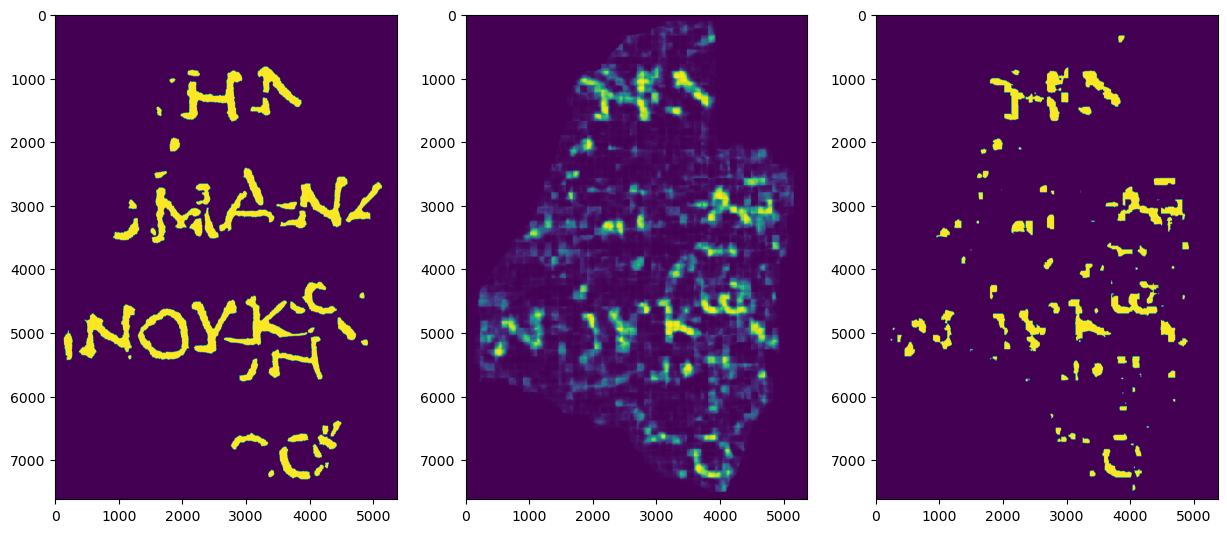

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([30856347.,  3131484.,  1465861.,   983510.,   700165.,   514103.,
          425603.,   374040.,   312851.,   272509.,   240829.,   215098.,
          202772.,   197248.,   177055.,   166565.,   157817.,   167029.,
          192330.,   190400.]),
 array([1.06721363e-05, 4.98008391e-02, 9.95910060e-02, 1.49381173e-01,
        1.99171340e-01, 2.48961507e-01, 2.98751674e-01, 3.48541841e-01,
        3.98332007e-01, 4.48122174e-01, 4.97912341e-01, 5.47702508e-01,
        5.97492675e-01, 6.47282842e-01, 6.97073009e-01, 7.46863176e-01,
        7.96653343e-01, 8.46443510e-01, 8.96233677e-01, 9.46023844e-01,
        9.95814011e-01]),
 <BarContainer object of 20 artists>)

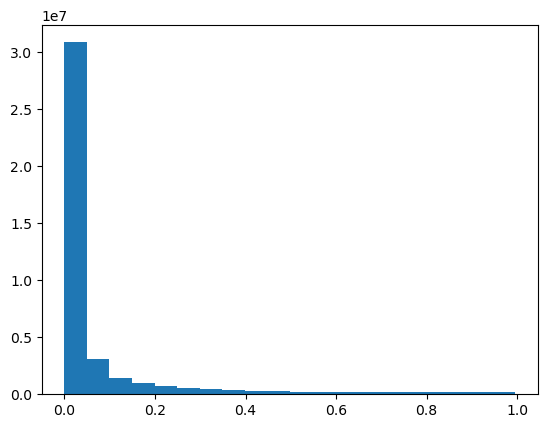

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000